In [1]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

# weightVar = 1.3**2

# dataVar = 2.5**2
# dataMean = 1

n_hidden = 128.0
n_dim = 3.0

# biasVar = 0

n_iterations = 30
qStart = 0.0

def integrand(z, prev_q):
    return np.tanh(np.sqrt(prev_q) * z)**2 * 1.0/np.sqrt(2.0 * np.pi) * np.exp(-(z**2)/2.0)

def test(z, a):
    return a*z**2

# nextq = weightVar * n_hidden * quad(integrad, -np.inf, np.inf, args=(qStart)) 
# + weightVar * n_dim * (dataVar + dataMean**2) + biasVar
def simulate(weightVar, dataVar, dataMean, biasVar):
    dynamics = np.zeros(n_iterations)
    for i in range(n_iterations):
        if i == 0:
            dynamics[i] = qStart
        else:
            dynamics[i] = weightVar * quad(integrand, -np.inf, np.inf, args=(dynamics[i-1]))[0] \
            + weightVar * (n_dim/n_hidden) * (dataVar + dataMean**2) + biasVar
    return dynamics

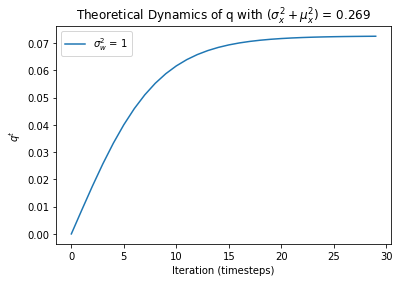

[ 0.          0.00880146  0.01745174  0.02567242  0.03324355  0.04002088
  0.04593707  0.05099065  0.05522878  0.05872908  0.0615839   0.06388862
  0.06573405  0.06720206  0.06836377  0.06927933  0.06999856  0.07056213
  0.07100285  0.07134696  0.07161533  0.07182441  0.0719872   0.07211386
  0.07221237  0.07228897  0.0723485   0.07239476  0.07243071  0.07245864]


In [8]:
weightStd = [0.03]
weightVar = [i**2 for i in weightStd]
biasVar = 0.05
# dataVar = [0, 0.5, 1.5, 2.5]
dataVar = 0.194413273048
dataMean = 0.27285383514 # Calculated from data set
plt.figure(1)
for el in weightVar:
    output = simulate(el, dataVar, dataMean, biasVar)
    plt.plot(output, label=r'$\sigma_w^2$ = %.2g' % el)
    plt.xlabel("Iteration (timesteps)")
    plt.ylabel(r'$q^t$')
    plt.title(r'Theoretical Dynamics of q with $(\sigma_x^2 + \mu_x^2)$ = %.3f' % (dataVar + dataMean**2))
plt.legend()
plt.show()
print(output)

In [2]:
import pickle
import random
data_string = 'lorAtt_80'
with open('lorAttData/%s.pickle' % (data_string), 'rb') as f: #Eventually take the file name as an argument
    data = pickle.load(f)
random.seed(12345)


In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import math
import matplotlib.pyplot as plot
%matplotlib inline

traj = data[random.randint(0,len(data))]
traj = torch.FloatTensor(traj)

weight_std = 0.03
weight_mean = 0.0
bias_mean = 0.0
bias_std = math.sqrt(0.05)

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.activation = nn.Tanh()
        
        for m in self.modules():
                if isinstance(m, torch.nn.Linear):
                    m.weight.data.normal_(weight_mean, weight_std)
                    m.bias.data.normal_(bias_mean, bias_std)
        
    def forward(self, input, hidden):
        combined = torch.cat([input, hidden], 1)
        hidden = self.i2h(combined)
        hidden = self.activation(hidden)
        output = self.i2o(combined)
        return output, hidden
    
    def initHidden(self):
        return Variable(torch.zeros(1,self.hidden_size)) 
    
hidden_features = 128
n_dim = traj.size()[2]


10000


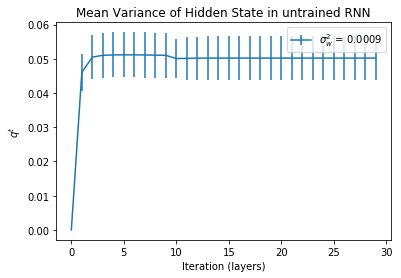

In [5]:
variance_all = []
for j in range(len(data)):
    traj = data[j]
    encoderRNN = RNN(n_dim, hidden_features, n_dim)
    decoderRNN = RNN(n_dim, hidden_features, n_dim)
    traj = torch.FloatTensor(traj)

    input_sequence_length = 9
    variances = []
    hidden = encoderRNN.initHidden()
    variances.append(np.var(hidden.data.numpy()[0]))
    traj = Variable(traj)
    output_sequence_length = traj.size()[0] - input_sequence_length

    encoderOutput = Variable(torch.zeros(input_sequence_length, 1, n_dim)) 
    decoderOutput = Variable(torch.zeros(output_sequence_length,1, n_dim))

    # Run the training sequence into the encoder
    for i in range(input_sequence_length):
        encoderOutput[i], hidden = encoderRNN(traj[i], hidden)
        variances.append(np.var(hidden.data.numpy()[0]))

    # Now the last hidden state of the encoder is the first hidden state of the decoder.
    # For now, let's have the first input be the origin
    for i in range(output_sequence_length):
        if (i == 0):
            dummyState = Variable(torch.zeros(1,n_dim)) 
            decoderOutput[i], hidden = decoderRNN(dummyState, hidden)
            variances.append(np.var(hidden.data.numpy()[0]))
        else:
            decoderOutput[i], hidden = decoderRNN(decoderOutput[i-1], hidden)
            variances.append(np.var(hidden.data.numpy()[0]))
    if j == 0:
        variance_all = variances
    else:
        variance_all = np.vstack((variance_all, variances))
variance_mean = []
variance_std = []
for i in range(traj.size()[0]):
    variance_mean.append(np.mean(variance_all[:,i]))
    variance_std.append(np.sqrt(np.var(variance_all[:,i])))
print(len(variance_all))
variances = variance_mean
plt.errorbar(range(traj.size()[0]) ,variances, yerr=variance_std,  label=r'$\sigma_w^2$ = %g' % (weight_std**2))
plt.xlabel("Iteration (layers)")
plt.ylabel(r'$q^t$')
plt.title('Mean Variance of Hidden State in untrained RNN')
plt.legend()
plt.show()

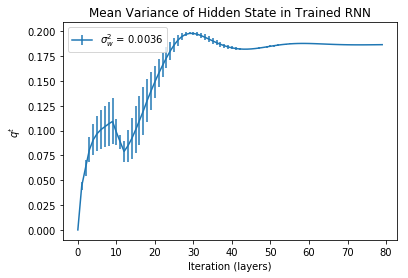

In [4]:
variance_all = []
for j in range(len(data)):
    traj = data[j]
    trainedEncoder = RNN(n_dim, hidden_features, n_dim)
    trainedDecoder = RNN(n_dim, hidden_features, n_dim)
    weight_std = 0.06
    trainedEncoder.load_state_dict(torch.load('savedResults/run_11/TrajModel/lorAtt_80_encoder_wsd_%.2f' % weight_std))
    trainedDecoder.load_state_dict(torch.load('savedResults/run_11/TrajModel/lorAtt_80_decoder_wsd_%.2f' % weight_std))
    traj = torch.FloatTensor(traj)

    input_sequence_length = 9
    variances = []
    hidden = trainedEncoder.initHidden()
    variances.append(np.var(hidden.data.numpy()[0]))
    traj = Variable(traj)
    output_sequence_length = traj.size()[0] - input_sequence_length

    encoderOutput = Variable(torch.zeros(input_sequence_length, 1, n_dim)) 
    decoderOutput = Variable(torch.zeros(output_sequence_length,1, n_dim))

    # Run the training sequence into the encoder
    for i in range(input_sequence_length):
        encoderOutput[i], hidden = trainedEncoder(traj[i], hidden)
        variances.append(np.var(hidden.data.numpy()[0]))

    # Now the last hidden state of the encoder is the first hidden state of the decoder.
    # For now, let's have the first input be the origin
    for i in range(output_sequence_length):
        if (i == 0):
            dummyState = Variable(torch.zeros(1,n_dim)) 
            decoderOutput[i], hidden = trainedDecoder(dummyState, hidden)
            variances.append(np.var(hidden.data.numpy()[0]))
        else:
            decoderOutput[i], hidden = trainedDecoder(decoderOutput[i-1], hidden)
            variances.append(np.var(hidden.data.numpy()[0]))
    if j == 0:
        variance_all = variances
    else:
        variance_all = np.vstack((variance_all, variances))
variance_mean = []
variance_std = []
for i in range(traj.size()[0]):
    variance_mean.append(np.mean(variance_all[:,i]))
    variance_std.append(np.sqrt(np.var(variance_all[:,i])))
    
variances = variance_mean
plt.errorbar(range(traj.size()[0]) ,variances, yerr=variance_std,  label=r'$\sigma_w^2$ = %g' % (weight_std**2))
plt.xlabel("Iteration (layers)")
plt.ylabel(r'$q^t$')
plt.title('Mean Variance of Hidden State in Trained RNN')
plt.legend()
plt.show()

In [145]:
print(len(data))

10000
